In [1]:
! pip install -q umap-learn

In [2]:
%%writefile loss.py
import torch
import torch.nn as nn
import torch.nn.functional as F


class LabelDifference(nn.Module):
    def __init__(self, distance_type="l1"):
        super(LabelDifference, self).__init__()
        self.distance_type = distance_type

    def forward(self, labels):
        # labels: [bs, label_dim]
        # output: [bs, bs]
        if self.distance_type == "l1":
            return torch.abs(labels[:, None, :] - labels[None, :, :]).sum(dim=-1)
        else:
            raise ValueError(self.distance_type)


class FeatureSimilarity(nn.Module):
    def __init__(self, similarity_type="l2"):
        super(FeatureSimilarity, self).__init__()
        self.similarity_type = similarity_type

    def forward(self, features):
        # labels: [bs, feat_dim]
        # output: [bs, bs]
        if self.similarity_type == "l2":
            return -(features[:, None, :] - features[None, :, :]).norm(2, dim=-1)
        else:
            raise ValueError(self.similarity_type)


class RnCLoss(nn.Module):
    def __init__(self, temperature=2, label_diff="l1", feature_sim="l2"):
        super(RnCLoss, self).__init__()
        self.t = temperature
        self.label_diff_fn = LabelDifference(label_diff)
        self.feature_sim_fn = FeatureSimilarity(feature_sim)

    def forward(self, features, labels):
        # features: [bs, 2, feat_dim]
        # labels: [bs, label_dim]

        features = torch.cat([features[:, 0], features[:, 1]], dim=0)  # [2bs, feat_dim]
        labels = labels.repeat(2, 1)  # [2bs, label_dim]

        label_diffs = self.label_diff_fn(labels)
        logits = self.feature_sim_fn(features).div(self.t)
        logits_max, _ = torch.max(logits, dim=1, keepdim=True)
        logits -= logits_max.detach()
        exp_logits = logits.exp()

        n = logits.shape[0]  # n = 2bs

        # remove diagonal
        logits = logits.masked_select((1 - torch.eye(n).to(logits.device)).bool()).view(
            n, n - 1
        )
        exp_logits = exp_logits.masked_select(
            (1 - torch.eye(n).to(logits.device)).bool()
        ).view(n, n - 1)
        label_diffs = label_diffs.masked_select(
            (1 - torch.eye(n).to(logits.device)).bool()
        ).view(n, n - 1)

        loss = 0.0
        for k in range(n - 1):
            pos_logits = logits[:, k]  # 2bs
            pos_label_diffs = label_diffs[:, k]  # 2bs
            neg_mask = (
                label_diffs >= pos_label_diffs.view(-1, 1)
            ).float()  # [2bs, 2bs - 1]
            pos_log_probs = pos_logits - torch.log(
                (neg_mask * exp_logits).sum(dim=-1)
            )  # 2bs
            loss += -(pos_log_probs / (n * (n - 1))).sum()

        return loss


Writing loss.py


In [3]:
%%writefile convnext.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.layers import DropPath, trunc_normal_


class Block(nn.Module):
    def __init__(self, dim, drop_path=0.0, layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv1d(
            dim, dim, kernel_size=7, padding=3, groups=dim
        )  # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(
            dim, 4 * dim
        )  # pointwise conv, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = (
            nn.Parameter(layer_scale_init_value * torch.ones((dim)), requires_grad=True)
            if layer_scale_init_value > 0
            else None
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 1)  # (N, C, W) -> (N, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 2, 1)  # (N, W, C) -> (N, C, W)
        x = input + self.drop_path(x)
        return x


class ConvNeXt(nn.Module):
    def __init__(
        self,
        in_chans=1,
        num_classes=1000,
        depths=[3, 3, 9, 3],
        dims=[96, 192, 384, 768],
        drop_path_rate=0.0,
        layer_scale_init_value=1e-6,
        head_init_scale=1.0,
    ):
        super().__init__()

        self.downsample_layers = (
            nn.ModuleList()
        )  # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv1d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first"),
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                nn.Conv1d(dims[i], dims[i + 1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = (
            nn.ModuleList()
        )  # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[
                    Block(
                        dim=dims[i],
                        drop_path=dp_rates[cur + j],
                        layer_scale_init_value=layer_scale_init_value,
                    )
                    for j in range(depths[i])
                ]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6)  # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv1d, nn.Linear)):
            trunc_normal_(m.weight, std=0.02)
            nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean(-1))  # global average pooling, (N, C, W) -> (N, C)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x


class LayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape,)

    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(
                x, self.normalized_shape, self.weight, self.bias, self.eps
            )
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None] * x + self.bias[:, None]
            return x


def convnext_tiny(**kwargs):
    model = ConvNeXt(depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], **kwargs)
    return model


def convnext_small(**kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[96, 192, 384, 768], **kwargs)
    return model


def convnext_base(**kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[128, 256, 512, 1024], **kwargs)
    return model


def convnext_large(**kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[192, 384, 768, 1536], **kwargs)
    return model


def convnext_xlarge(**kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[256, 512, 1024, 2048], **kwargs)
    return model


Writing convnext.py


In [4]:
%%writefile ppg_dalia.py
import glob
import os

import mne
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

data_dir = "/kaggle/input/ppg-dalia-processed"
filepaths = glob.glob(os.path.join(data_dir, "*.npz"))

# 80%-10%-10%
train_files, test_files = train_test_split(
    filepaths,
    test_size=0.2,
    shuffle=True,
    random_state=42,
)
val_files, test_files = train_test_split(
    test_files,
    test_size=0.5,
    shuffle=True,
    random_state=42,
)

files = {
    "train": train_files,
    "val": val_files,
    "test": test_files,
}
ecgs = {"train": [], "val": [], "test": []}
ppgs = {"train": [], "val": [], "test": []}

labels = {"train": [], "val": [], "test": []}

for split in ["train", "val", "test"]:
    for file in files[split]:
        data = np.load(file)
        ecg = data["ecg"]
        ppg = data["ppg"]
        label = data["label"]
        ecg_resampled = mne.filter.resample(ecg.astype(float), down=700 / 64)

        ecgs[split].append(ecg_resampled)
        ppgs[split].append(ppg)
        labels[split].append(label)

    ecgs[split] = np.concatenate(ecgs[split], axis=0)
    ppgs[split] = np.concatenate(ppgs[split], axis=0)
    labels[split] = np.concatenate(labels[split], axis=0)

mean, std = labels["train"].mean(), labels["train"].std()


def normalize_labels(label):
    return (label - mean) / std


def unnormalize_labels(label):
    return std * label + mean


class PPG_DaLiA(Dataset):

    def __init__(self, ecgs, ppgs, labels):
        self.ecgs = (ecgs - np.min(ecgs)) / (np.max(ecgs) - np.min(ecgs))
        self.ppgs = (ppgs - np.min(ppgs)) / (np.max(ppgs) - np.min(ppgs))
        self.labels = normalize_labels(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        ecg = torch.as_tensor(self.ecgs[index], dtype=torch.float32)
        ppg = torch.as_tensor(self.ppgs[index], dtype=torch.float32)
        label = torch.as_tensor(self.labels[index], dtype=torch.float32)

        ecg = ecg.unsqueeze(0)
        ppg = ppg.unsqueeze(0)
        label = label.unsqueeze(0)

        return ecg, ppg, label


dataset = {
    "train": PPG_DaLiA(ecgs["train"], ppgs["train"], labels["train"]),
    "val": PPG_DaLiA(ecgs["val"], ppgs["val"], labels["val"]),
    "test": PPG_DaLiA(ecgs["test"], ppgs["test"], labels["test"]),
}


Writing ppg_dalia.py


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchmetrics.aggregation import MeanMetric
from tqdm.auto import tqdm

from convnext import ConvNeXt
from loss import RnCLoss
from ppg_dalia import dataset, unnormalize_labels

device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 32
train_loader = DataLoader(dataset["train"], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset["val"], batch_size=batch_size)
test_loader = DataLoader(dataset["test"], batch_size=batch_size)

ecg_enc = ConvNeXt(depths=[3, 3, 9, 3], dims=[32, 64, 128, 256], num_classes=1)
ecg_enc.to(device)

ppg_enc = ConvNeXt(depths=[3, 3, 9, 3], dims=[32, 64, 128, 256], num_classes=1)
ppg_enc.to(device)

model_size = 0
for param in ppg_enc.parameters():
    model_size += param.data.nelement()
print("Model params: %.2f M" % (model_size / 1024 / 1024))

# Pretraining: Rank-N-Constrast
epochs = 20
lr = 3e-4
optimizer_ppg = torch.optim.Adam(ppg_enc.parameters(), lr=lr)
optimizer_ecg = torch.optim.Adam(ecg_enc.parameters(), lr=lr)
criterion = RnCLoss(temperature=2, label_diff="l1", feature_sim="l2")

avg_loss = MeanMetric()
train_losses = []
val_mae = []

pbar = tqdm(total=epochs*len(train_loader))

for epoch in range(epochs):
    for ecgs, ppgs, labels in train_loader:
        ecgs = ecgs.to(device)
        ppgs = ppgs.to(device)
        labels = labels.to(device)

        ecg_feats = ecg_enc.forward_features(ppgs)
        ppg_feats = ppg_enc.forward_features(ppgs)
        feats = torch.stack([ecg_feats, ppg_feats], dim=1)
        rnc_loss = criterion(feats, labels)
        
        preds = ppg_enc.head(ppg_feats)
        l2_loss = F.mse_loss(preds, labels)
        
        loss = 0.2*l2_loss + 0.8*rnc_loss

        optimizer_ecg.zero_grad()
        optimizer_ppg.zero_grad()
        loss.backward()
        optimizer_ecg.step()
        optimizer_ppg.step()

        train_losses.append(loss.item())
        avg_loss.update(loss.item())
        pbar.update()
    
    batched_errors = []
    for _, inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            preds = ppg_enc(inputs)

        errors = F.l1_loss(
            unnormalize_labels(preds),
            unnormalize_labels(labels),
            reduction="none",
        )
        batched_errors.append(errors.cpu().numpy())

    batched_errors = np.concatenate(batched_errors, axis=0)
    mae = np.mean(batched_errors)
    val_mae.append(mae)
    
    print(f"Epoch={epoch}, Train/Loss={avg_loss.compute():.2f}, Val/MAE={mae:.2f}")
    avg_loss.reset()

pbar.close()

Model params: 2.86 M


  0%|          | 0/32160 [00:00<?, ?it/s]

Epoch=0, Train/Loss=2.79, Val/MAE=15.86
Epoch=1, Train/Loss=2.40, Val/MAE=10.90
Epoch=2, Train/Loss=2.27, Val/MAE=11.76
Epoch=3, Train/Loss=2.20, Val/MAE=7.93
Epoch=4, Train/Loss=2.14, Val/MAE=8.95
Epoch=5, Train/Loss=2.09, Val/MAE=10.59
Epoch=6, Train/Loss=2.04, Val/MAE=8.71
Epoch=7, Train/Loss=2.00, Val/MAE=9.17
Epoch=8, Train/Loss=1.95, Val/MAE=9.13
Epoch=9, Train/Loss=1.90, Val/MAE=10.77
Epoch=10, Train/Loss=1.86, Val/MAE=10.00
Epoch=11, Train/Loss=1.82, Val/MAE=8.62
Epoch=12, Train/Loss=1.77, Val/MAE=9.64
Epoch=13, Train/Loss=1.77, Val/MAE=10.12
Epoch=14, Train/Loss=1.70, Val/MAE=9.11
Epoch=15, Train/Loss=1.68, Val/MAE=8.83
Epoch=16, Train/Loss=1.66, Val/MAE=8.56
Epoch=17, Train/Loss=1.63, Val/MAE=10.39
Epoch=18, Train/Loss=1.60, Val/MAE=10.01
Epoch=19, Train/Loss=1.58, Val/MAE=8.35


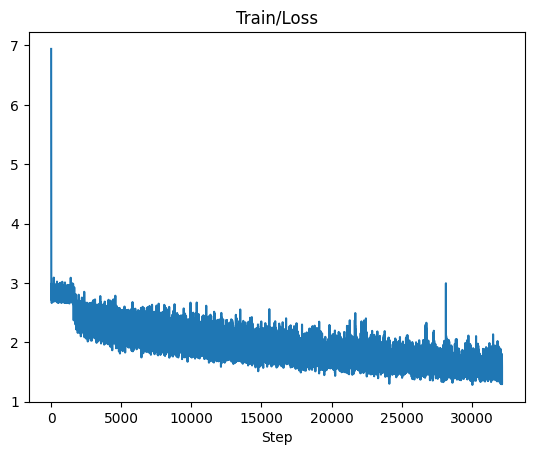

In [6]:
plt.plot(train_losses)
plt.xlabel("Step")
plt.title("Train/Loss")
plt.show()

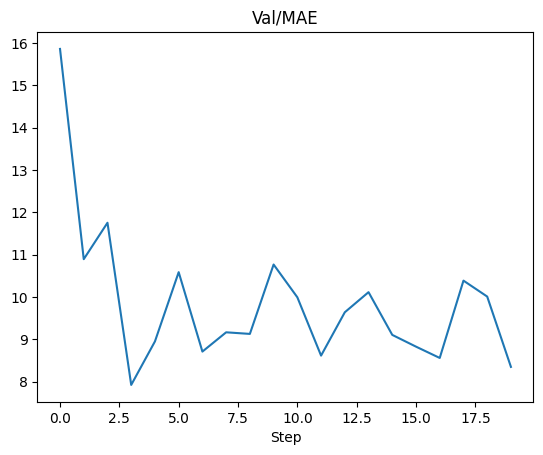

In [7]:
plt.plot(val_mae)
plt.xlabel("Step")
plt.title("Val/MAE")
plt.show()

In [8]:
model = ppg_enc

batched_errors = []
for _, inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        preds = model(inputs)

    errors = F.l1_loss(
        unnormalize_labels(preds), unnormalize_labels(labels), reduction='none',
    )
    batched_errors.append(errors.cpu().numpy())

batched_errors = np.concatenate(batched_errors, axis=0)
mae = np.mean(batched_errors)

print("Test MAE:", mae)

Test MAE: 8.233009


## Examining Feature Space

In [9]:
batched_feats = []
batched_labels = []
for _, inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        feats = model.forward_features(inputs)
    
    batched_feats.append(feats.cpu())
    batched_labels.append(labels.cpu())
    
feats = torch.cat(batched_feats, dim=0)
labels = torch.cat(batched_labels, dim=0)

In [10]:
import umap

feats_reduced = umap.UMAP().fit_transform(feats)

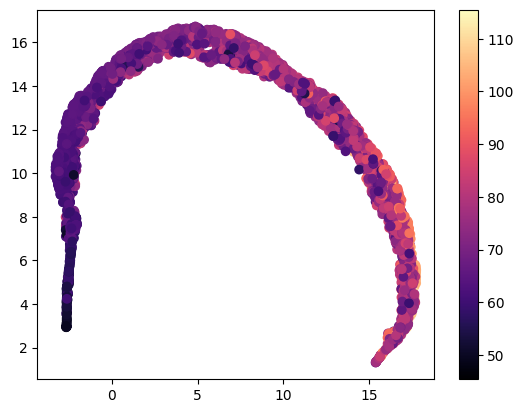

In [11]:
plt.scatter(
    feats_reduced[:, 0],
    feats_reduced[:, 1],
    c=unnormalize_labels(labels).squeeze(),
    cmap="magma",
)
plt.colorbar()
plt.show()